###  v2-clinical_notes_classification - using multiple models


In [1]:
import pandas as pd
import numpy as np
import sys, os
import statistics

from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Embedding
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.utils import plot_model

import tensorflow_hub as hub
import bert
from bert.tokenization.bert_tokenization import FullTokenizer

import hashlib

from tqdm import tqdm

In [2]:
svrcm_file = './data/clinical_notes.csv'
bert_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"


In [3]:
SEQUENCE_LEN = 200
assert SEQUENCE_LEN < 512, "The maximun permissible sequence length for BERT is 512"

BATCH_SIZE = 1
assert BATCH_SIZE < 33, "The tensor flow model.fit hangs up on last epoch for batch size > 32"

EPOCHS = 1
LEARNING_RATE = 1e-3


CATEGORIES = ['allergies',
 'chief_complaint',
 'cpt_code',
 'current_medication',
 'diag_code',
 'examination',
 'fam_hist',
 'hosp_hist',
 'illness_hist',
 'med_hist',
 'modifier',
 'social_hist',
 'surg_hist',
 'uncategorized']
MODEL_NAMES = ["burt_only", "burt_LTSM128", "burt_LTSM256", "embd_LTSM256"]

In [4]:
print("tensorflow version ->", tf.__version__)
print("sys/python version ->", sys.version)
np.set_printoptions(suppress=True, precision=2)


tensorflow version -> 2.1.0
sys/python version -> 3.7.7 (default, Mar 10 2020, 15:43:33) 
[Clang 11.0.0 (clang-1100.0.33.17)]


### utilities

In [5]:
def validate_categories(df):
    values = df.values
    arr_binary = np.in1d(values, CATEGORIES)
    bad_rows = np.flatnonzero(arr_binary == False)
    excel_bad_rows = bad_rows+2
    if excel_bad_rows.size>0 :
        print("DATA ERRORS -> clinical_notes.csv file as following excel rows with bad categories:\n",
              excel_bad_rows)
    return

In [6]:
def validate_clinical_notes(df):
    len_arr = [len(note) for note in df]
    len_arr.sort()
    print("df_notes -> shape {}, min_len {}, max_len {}, mean {}, median {}".format(
        df.shape, len_arr[0], len_arr[-1],
        int(statistics.mean(len_arr)), int(statistics.median(len_arr))))
    assert  len_arr[-1] < SEQUENCE_LEN, "notes include a line greater than max allowed"
    return

### dataset

In [7]:
def download_clinical_notes(svrcm_file):
    df_notes = pd.read_csv(svrcm_file, engine='python')
    validate_categories(df_notes['category'])
    validate_clinical_notes(df_notes['notes'])
    
    return df_notes

df_notes = download_clinical_notes(svrcm_file)

df_notes -> shape (210,), min_len 2, max_len 175, mean 59, median 54


In [8]:
def create_patient_dataset(df):
    df_1 = df.groupby(['id'])['notes'].apply(list)
    df_2 = df.groupby(['id'])['category'].apply(list)
    df_dataset = pd.concat([df_1, df_2], axis=1)
    df_dataset.reset_index(inplace=True)
    print("df_dataset (patients, col)->", df_dataset.shape)
    assert (df_dataset.shape[0]==len(df.id.unique()) and
            df_dataset.shape[1]==3 ), "df_dataset shape mismatch"
    return df_dataset

df_dataset = create_patient_dataset(df_notes)

df_dataset (patients, col)-> (9, 3)


In [9]:
df_dataset

,id,notes,category
0,11111,[Reason for appointment Patient has history of...,"[chief_complaint, chief_complaint, chief_compl..."
1,11112,[Patient FC presents with following complaints...,"[chief_complaint, chief_complaint, illness_his..."
2,11113,[Patient complains of blurred vision and occas...,"[chief_complaint, chief_complaint, illness_his..."
3,11114,"[Patient presents for retinal evaluation. , ...","[chief_complaint, chief_complaint, illness_his..."
4,11115,[Patient presents with postop care same day le...,"[chief_complaint, allergies, hosp_hist, examin..."
5,11116,"[Patient has medical condition hypertension. ,...","[chief_complaint, chief_complaint, chief_compl..."
6,11117,[Patient has history of diabetes presents for ...,"[chief_complaint, illness_hist, illness_hist, ..."
7,11118,[Patient is known case of wet macular degenera...,"[chief_complaint, cpt_code, diag_code, cpt_cod..."
8,81118,[Patient complains of occasional floaters in t...,"[chief_complaint, illness_hist, examination, e..."


### X & Y

In [10]:
bert_layer = hub.KerasLayer(bert_url, trainable=False, name="BERT")

In [11]:
def get_tokenizer():
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    print("vocab file located at:\n", vocab_file)
    tokenizer = FullTokenizer(vocab_file)
    
    print("testing access to vocab.txt")
    print("'corona' ->" , tokenizer.convert_tokens_to_ids(['corona']))
    print("'21887' ->" , tokenizer.convert_ids_to_tokens([21887]))
    return tokenizer

tokenizer = get_tokenizer()

vocab file located at:
 b'/Users/bp/tf-hub-cache/03d6fb3ce1605ad9e5e9ed5346b2fb9623ef4d3d/assets/vocab.txt'
testing access to vocab.txt
'corona' -> [21887]
'21887' -> ['corona']


In [12]:
def get_masks(tokens):
    masks = [1]*len(tokens) + [0]*(SEQUENCE_LEN - len(tokens))
    return masks

In [13]:
def get_segments(tokens):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    segments = segments + [0]*(SEQUENCE_LEN - len(tokens)) 
    return segments

In [14]:
def get_ids(tokens):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    token_ids = token_ids + [0]*(SEQUENCE_LEN - len(token_ids))
    return token_ids

In [15]:
def create_single_input(sample):
    sample_tokens = tokenizer.tokenize(sample)
    sample_tokens = sample_tokens[:(SEQUENCE_LEN-2)]
    sample_tokens = ["[CLS]"] + sample_tokens + ["[SEP]"]
    
    ids = get_ids(sample_tokens)
    masks = get_masks(sample_tokens)
    segments = get_segments(sample_tokens)

    return ids, masks, segments

In [16]:
def create_triple_input(patient):
    input_ids, input_masks, input_segments = [], [], []

    for line in patient:
        ids, masks, segments = create_single_input(line)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)

    triple_input = [np.asarray(input_ids, dtype=np.int32),
                    np.asarray(input_masks, dtype=np.int32), 
                    np.asarray(input_segments, dtype=np.int32)]
    print("triple_input type: {}, len: {}, each with shape: {}".format(
        type(triple_input), len(triple_input), triple_input[0].shape))

    return triple_input

### Dataset  Preparation

In [17]:
def append_triple_input(df):
    if df.shape[1] != 3:
        print("already executed or df_dataset is not ready for this operation")
        return df
    df_X_notes = pd.Series(dtype=object)
    for i, row in enumerate(df['notes'].values):
        triple_input = create_triple_input(row)
        df_X_notes.loc[i] = triple_input
        
    df_X_notes = df_X_notes.to_frame('X_notes')
    df1 = df.reset_index().merge(df_X_notes, left_index=True, 
                                 right_index=True)
    df1 = df1.drop('index', 1)
    print("df_dataset ->", df1.shape)
    return df1

df_dataset = append_triple_input(df_dataset)

triple_input type: <class 'list'>, len: 3, each with shape: (52, 200)
triple_input type: <class 'list'>, len: 3, each with shape: (29, 200)
triple_input type: <class 'list'>, len: 3, each with shape: (36, 200)
triple_input type: <class 'list'>, len: 3, each with shape: (34, 200)
triple_input type: <class 'list'>, len: 3, each with shape: (12, 200)
triple_input type: <class 'list'>, len: 3, each with shape: (17, 200)
triple_input type: <class 'list'>, len: 3, each with shape: (14, 200)
triple_input type: <class 'list'>, len: 3, each with shape: (5, 200)
triple_input type: <class 'list'>, len: 3, each with shape: (11, 200)
df_dataset -> (9, 4)


In [19]:
df_dataset

,id,notes,category,X_notes
0,11111,[Reason for appointment Patient has history of...,"[chief_complaint, chief_complaint, chief_compl...","[[[101, 3114, 2005, 6098, 5776, 2038, 2381, 19..."
1,11112,[Patient FC presents with following complaints...,"[chief_complaint, chief_complaint, illness_his...","[[[101, 5776, 4429, 7534, 2007, 2206, 10821, 2..."
2,11113,[Patient complains of blurred vision and occas...,"[chief_complaint, chief_complaint, illness_his...","[[[101, 5776, 17612, 2015, 1997, 18449, 4432, ..."
3,11114,"[Patient presents for retinal evaluation. , ...","[chief_complaint, chief_complaint, illness_his...","[[[101, 5776, 7534, 2005, 2128, 13770, 2140, 9..."
4,11115,[Patient presents with postop care same day le...,"[chief_complaint, allergies, hosp_hist, examin...","[[[101, 5776, 7534, 2007, 2695, 7361, 2729, 21..."
5,11116,"[Patient has medical condition hypertension. ,...","[chief_complaint, chief_complaint, chief_compl...","[[[101, 5776, 2038, 2966, 4650, 23760, 29048, ..."
6,11117,[Patient has history of diabetes presents for ...,"[chief_complaint, illness_hist, illness_hist, ...","[[[101, 5776, 2038, 2381, 1997, 14671, 7534, 2..."
7,11118,[Patient is known case of wet macular degenera...,"[chief_complaint, cpt_code, diag_code, cpt_cod...","[[[101, 5776, 2003, 2124, 2553, 1997, 4954, 60..."
8,81118,[Patient complains of occasional floaters in t...,"[chief_complaint, illness_hist, examination, e...","[[[101, 5776, 17612, 2015, 1997, 8138, 14257, ..."


In [20]:
def one_hot_encode_utility(df):
    lb = LabelBinarizer()
    lb.fit_transform(CATEGORIES)
    one_hot_labels = lb.transform(df)
    
    print('one_hot_labels ->', type(one_hot_labels), one_hot_labels.shape)
    assert (one_hot_labels.shape[1]==len(CATEGORIES)), "categories do not match with one_hot_labels"
    assert (one_hot_labels.shape[0]==len(df)), "inconsistent number of samples processed"
    return one_hot_labels

In [23]:
def append_hot_encode_category(df):
    if df.shape[1] != 4:
        print("already executed or df_dataset is not ready for this operation")
        return df

    arr = df['category'].values
    df_Y_category = pd.Series(dtype=object)
    for i, row in enumerate(arr):
        df_Y_category.loc[i] = one_hot_encode_utility(row)
    df_Y_category = df_Y_category.to_frame('Y_category')
    df1 = df.reset_index().merge(df_Y_category, left_index=True, 
                                 right_index=True)
    del df1['index']
    print("df_dataset ->", df1.shape)
    return df1

df_dataset = append_hot_encode_category(df_dataset)

already executed or df_dataset is not ready for this operation


In [24]:
df_dataset

,id,notes,category,X_notes,Y_category
0,11111,[Reason for appointment Patient has history of...,"[chief_complaint, chief_complaint, chief_compl...","[[[101, 3114, 2005, 6098, 5776, 2038, 2381, 19...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
1,11112,[Patient FC presents with following complaints...,"[chief_complaint, chief_complaint, illness_his...","[[[101, 5776, 4429, 7534, 2007, 2206, 10821, 2...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
2,11113,[Patient complains of blurred vision and occas...,"[chief_complaint, chief_complaint, illness_his...","[[[101, 5776, 17612, 2015, 1997, 18449, 4432, ...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
3,11114,"[Patient presents for retinal evaluation. , ...","[chief_complaint, chief_complaint, illness_his...","[[[101, 5776, 7534, 2005, 2128, 13770, 2140, 9...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
4,11115,[Patient presents with postop care same day le...,"[chief_complaint, allergies, hosp_hist, examin...","[[[101, 5776, 7534, 2007, 2695, 7361, 2729, 21...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
5,11116,"[Patient has medical condition hypertension. ,...","[chief_complaint, chief_complaint, chief_compl...","[[[101, 5776, 2038, 2966, 4650, 23760, 29048, ...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
6,11117,[Patient has history of diabetes presents for ...,"[chief_complaint, illness_hist, illness_hist, ...","[[[101, 5776, 2038, 2381, 1997, 14671, 7534, 2...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
7,11118,[Patient is known case of wet macular degenera...,"[chief_complaint, cpt_code, diag_code, cpt_cod...","[[[101, 5776, 2003, 2124, 2553, 1997, 4954, 60...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
8,81118,[Patient complains of occasional floaters in t...,"[chief_complaint, illness_hist, examination, e...","[[[101, 5776, 17612, 2015, 1997, 8138, 14257, ...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."


In [25]:
df_dataset['notes'][8]

['Patient complains of occasional floaters in the left eye. ',
 '  Her past ocular history is significant for status post ',
 '  YAG laser capsulotomy in both eyes and pseudophakia. ',
 ' She also has history of mild amblyopia in the left eye ',
 '  Refraction shows In the right eye its 20/50 and in the left eye it is -1 0.5+0.75 at 30 degrees 20/50 ',
 '  Slit-lamp examination Default values for all except in the lens there is posterior chamber intraocular lens well-positioned in both eyes.',
 '   Retinal examination default values vitreous clear optic nerve pink ',
 ' macula good reflex vessels patent periphery attached ',
 '  However there is floaters in both eyes. ',
 ' Diagnosis Amblyopia left eye PVD left eye Pseudophakia both eyes. End ',
 'OU']

In [26]:
df_dataset['X_notes'][7][0][0][1]

5776

In [27]:
tokenizer.convert_ids_to_tokens([5776])

['patient']

In [28]:
len(tokenizer.vocab)

30522

In [29]:
def build_meta_model():
    models = []
    input_word_ids = Input(shape=(SEQUENCE_LEN,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(SEQUENCE_LEN,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(SEQUENCE_LEN,), dtype=tf.int32, name="segment_ids")
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    for i in range(len(MODEL_NAMES)):
        if i==0:
            pred_label = Dense(len(CATEGORIES), activation="softmax", name='pred_label')(pooled_output)
        elif i==1:
            lstm_layer = Bidirectional(LSTM(128))(sequence_output)
            pred_label = Dense(len(CATEGORIES), activation="softmax", name='pred_label')(lstm_layer)
        elif i==2:
            lstm_layer = Bidirectional(LSTM(256))(sequence_output)
            pred_label = Dense(len(CATEGORIES), activation="softmax", name='pred_label')(lstm_layer)
        elif i==3:
            embeddings = Embedding(input_dim=len(tokenizer.vocab), output_dim=768)(input_word_ids)
            lstm_layer = Bidirectional(LSTM(256))(embeddings)
            pred_label = Dense(len(CATEGORIES), activation="softmax", name='pred_label')(lstm_layer)
        else:
            pass
        model = Model([input_word_ids, input_mask, segment_ids], outputs=pred_label, name=MODEL_NAMES[i])
        models.append(model)
        print("built models[{}] : {}{}".format(i, MODEL_NAMES[i], models[i]))
    return models


In [30]:
models = build_meta_model()

built models[0] : burt_only<tensorflow.python.keras.engine.training.Model object at 0x13e6d6f90>
built models[1] : burt_LTSM128<tensorflow.python.keras.engine.training.Model object at 0x13e7d9710>
built models[2] : burt_LTSM256<tensorflow.python.keras.engine.training.Model object at 0x13f0a8710>
built models[3] : embd_LTSM256<tensorflow.python.keras.engine.training.Model object at 0x1425ef1d0>


In [31]:
models[0].summary()

Model: "burt_only"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]         

In [32]:
models[1].summary()

Model: "burt_LTSM128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [33]:
models[2].summary()

Model: "burt_LTSM256"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [34]:
models[3].summary()

Model: "embd_LTSM256"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 768)     23440896    input_word_ids[0][0]             
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 512)          2099200     embedding[0][0]                  
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
_______________________________________________________________________________________

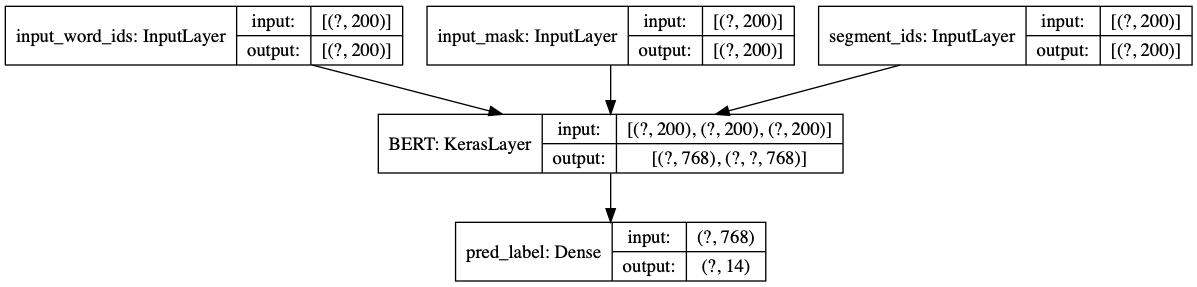

In [35]:
plot_model(models[0], MODEL_NAMES[0]+'.png', show_shapes=True)

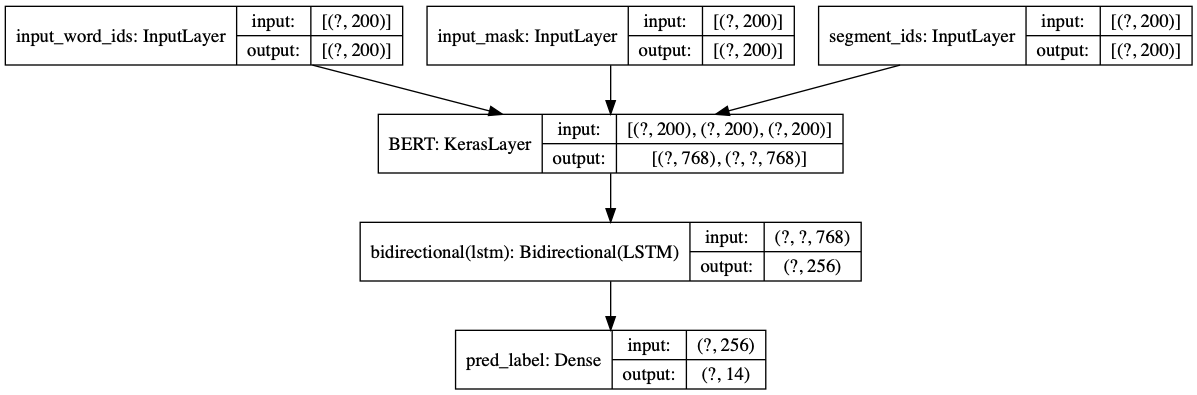

In [36]:
plot_model(models[1], MODEL_NAMES[1]+'.png', show_shapes=True)

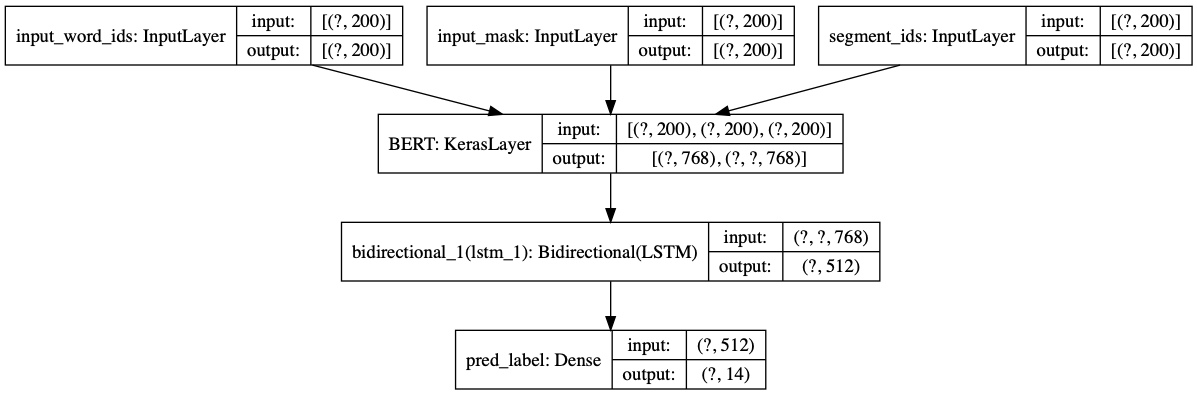

In [37]:
plot_model(models[2], MODEL_NAMES[2]+'.png', show_shapes=True)

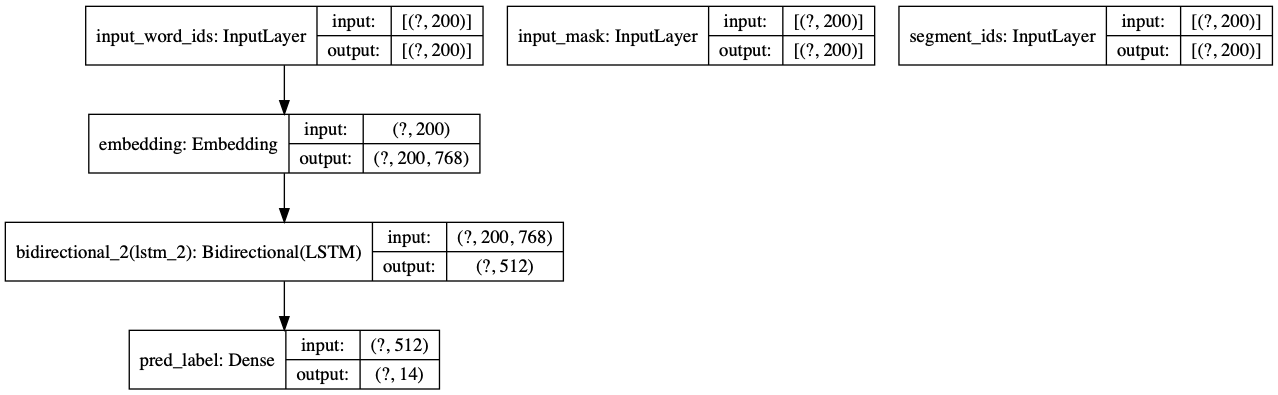

In [38]:
plot_model(models[3], MODEL_NAMES[0]+'.png', show_shapes=True)

# Model

In [39]:
loss_func = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [40]:
train_mean_loss = tf.keras.metrics.Mean(name="train_mean_loss")
train_acc = tf.keras.metrics.CategoricalAccuracy(name="train_acc")

In [41]:
def calculate_loss(Y_true, Y_pred,  training=False):
    loss = loss_func(tf.convert_to_tensor(Y_true), tf.convert_to_tensor(Y_pred))
    return loss

In [42]:
def wrapper_fn():
    @tf.function(experimental_relax_shapes=True)
    def train_step(model, X_input, Y_true):
        with tf.GradientTape() as tape:
            Y_pred = model(X_input)
            loss = calculate_loss(Y_true, Y_pred)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        mean_loss = train_mean_loss(loss)
        acc = train_acc(Y_true, Y_pred)
        return mean_loss, acc
    return train_step

In [43]:
# Begin training!#

def train_dataset(model_name, model, X_train):
    hist = {"mean_loss":[], "acc":[]}
    train_step_fn = model_name+"train_step"
    train_step_fn = wrapper_fn()

    if hasattr(tqdm, '_instances'): tqdm._instances.clear()  # clear if it exists
    for i in tqdm(range(EPOCHS)):    
        print("starting training model: {}, epoch# {} of {} ..".format(model_name, i+1, EPOCHS))
        
        for j, X_input  in enumerate(X_train):
            Y_true = df_dataset["Y_category"][j]
            
            mean_loss, acc = train_step_fn(model, X_input, Y_true )
            
            hist['mean_loss'].append(mean_loss.numpy())
            hist['acc'].append(acc.numpy())
            print("   finished {} samples in step# {} of {} mean_loss {}, acc {}".format(
                len(Y_true), j+1, len(X_train), mean_loss, acc))
    return hist

In [44]:
X_train = df_dataset["X_notes"][0:4]

In [45]:
X_train

0    [[[101, 3114, 2005, 6098, 5776, 2038, 2381, 19...
1    [[[101, 5776, 4429, 7534, 2007, 2206, 10821, 2...
2    [[[101, 5776, 17612, 2015, 1997, 18449, 4432, ...
3    [[[101, 5776, 7534, 2005, 2128, 13770, 2140, 9...
Name: X_notes, dtype: object

In [46]:
def train_meta_model(X_train):
    meta_hist = []
    for i in range(len(MODEL_NAMES)):
        hist = train_dataset(MODEL_NAMES[i], models[i], X_train)
        meta_hist.append(hist)
    return meta_hist

In [47]:
meta_hist = train_meta_model(X_train)

  0%|          | 0/1 [00:00<?, ?it/s]

starting training model: burt_only, epoch# 1 of 1 ..
   finished 52 samples in step# 1 of 4 mean_loss 2.687411308288574, acc 0.03846153989434242
   finished 29 samples in step# 2 of 4 mean_loss 2.5419387817382812, acc 0.12345679104328156
   finished 36 samples in step# 3 of 4 mean_loss 2.324989080429077, acc 0.2905983030796051


100%|██████████| 1/1 [00:49<00:00, 49.99s/it]

   finished 34 samples in step# 4 of 4 mean_loss 2.137502431869507, acc 0.3708609342575073



  0%|          | 0/1 [00:00<?, ?it/s]

starting training model: burt_LTSM128, epoch# 1 of 1 ..
   finished 52 samples in step# 1 of 4 mean_loss 2.311809539794922, acc 0.2857142984867096
   finished 29 samples in step# 2 of 4 mean_loss 2.3004581928253174, acc 0.3017241358757019
   finished 36 samples in step# 3 of 4 mean_loss 2.164639711380005, acc 0.35820895433425903


100%|██████████| 1/1 [00:49<00:00, 49.82s/it]

   finished 34 samples in step# 4 of 4 mean_loss 2.0575075149536133, acc 0.3907284736633301



  0%|          | 0/1 [00:00<?, ?it/s]

starting training model: burt_LTSM256, epoch# 1 of 1 ..
   finished 52 samples in step# 1 of 4 mean_loss 2.1098947525024414, acc 0.3502824902534485
   finished 29 samples in step# 2 of 4 mean_loss 2.071743965148926, acc 0.37075719237327576
   finished 36 samples in step# 3 of 4 mean_loss 1.9846354722976685, acc 0.4009546637535095


100%|██████████| 1/1 [00:53<00:00, 53.63s/it]

   finished 34 samples in step# 4 of 4 mean_loss 1.9397640228271484, acc 0.4194260537624359



  0%|          | 0/1 [00:00<?, ?it/s]

starting training model: embd_LTSM256, epoch# 1 of 1 ..
   finished 52 samples in step# 1 of 4 mean_loss 1.9934369325637817, acc 0.38019803166389465
   finished 29 samples in step# 2 of 4 mean_loss 2.029017686843872, acc 0.3932584226131439
   finished 36 samples in step# 3 of 4 mean_loss 2.042818546295166, acc 0.4140350818634033


100%|██████████| 1/1 [00:11<00:00, 11.20s/it]

   finished 34 samples in step# 4 of 4 mean_loss 2.0365891456604004, acc 0.4271523058414459


In [48]:
def plot_utility(data, xlabel, ylabel):

    plt.plot(data[0], 'r-.')
    plt.plot(data[1], 'b--')
    plt.plot(data[2], 'g-')
    plt.plot(data[3], 'b--')

    plt.legend([MODEL_NAMES[0], MODEL_NAMES[1], MODEL_NAMES[2], MODEL_NAMES[3]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show();
    return

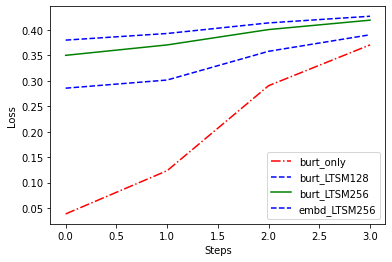

In [49]:
data = [meta_hist[i]['acc'] for i in range(len(meta_hist))]

plot_utility(data, "Steps", "Loss")

### Predictions

In [50]:
X_test = df_dataset["X_notes"]
Y_test = df_dataset["Y_category"]
Y_test_cat = df_dataset["category"]
id = df_dataset["id"]

In [51]:
def predict_step(model_name, model, id, notes, true_category):
    print("patient_id -> {}".format(id))
    assert len(notes)==3, "X length is inconsistent"
    assert len(true_category)==len(notes[0]), "Y length is inconsistent"
    df_step_result = None
    pred_category = []
    pred = model(notes)
    pred_max = np.argmax(pred , axis=1)
    [pred_category.append(CATEGORIES[val]) for val in pred_max]
    
    pred = model_name + "_pred"
    eval = model_name + "_eval"
    
    data = {"id":id, "true_category":true_category, pred:pred_category}
    df_step_result = pd.DataFrame.from_dict(data)
    df_step_result[eval] = np.where(df_step_result["true_category"] == df_step_result[pred], 100, 0)
    pass_count = (df_step_result[eval]==100).sum()
    pred_success = pass_count/len(df_step_result[eval])
    
    print("  model: {} -> patient notes: {} lines, pred_success : {:.0%}".format(
        model_name, df_step_result.shape[0], pred_success))
    
    return df_step_result                      

In [52]:
def predict_one_model(model_name, model, id, X_test, Y_test_cat):
    model_arr = np.array([])
    for i in range(len(X_test)):       
        df_step_result = predict_step(
            model_name, model, id[id.index[i]], X_test[X_test.index[i]], Y_test_cat[Y_test_cat.index[i]])
        model_arr = np.append(model_arr, df_step_result.to_numpy())
    model_arr = model_arr.reshape(-1,4)
    model_col_names = list(df_step_result)
    df_one_model = pd.DataFrame(model_arr, columns = model_col_names)
    print("df_one_model ->", df_one_model.shape)
    return df_one_model


In [53]:
def predict_all_models():
    df_models = pd.DataFrame()
    for i, model in enumerate(models):
        print("***** started processing model#{} *****".format(i))
        df_one_model = predict_one_model(MODEL_NAMES[i], model, id, X_test, Y_test_cat)
        df_models = pd.concat([df_models, df_one_model], axis=1) 
    df_models = df_models.loc[:, ~df_models.columns.duplicated()] 
    return df_models

In [54]:
df_models = predict_all_models()

***** started processing model#0 *****
patient_id -> 11111
  model: burt_only -> patient notes: 52 lines, pred_success : 54%
patient_id -> 11112
  model: burt_only -> patient notes: 29 lines, pred_success : 62%
patient_id -> 11113
  model: burt_only -> patient notes: 36 lines, pred_success : 72%
patient_id -> 11114


  model: burt_only -> patient notes: 34 lines, pred_success : 65%
patient_id -> 11115


  model: burt_only -> patient notes: 12 lines, pred_success : 33%
patient_id -> 11116


  model: burt_only -> patient notes: 17 lines, pred_success : 53%
patient_id -> 11117


  model: burt_only -> patient notes: 14 lines, pred_success : 57%
patient_id -> 11118


  model: burt_only -> patient notes: 5 lines, pred_success : 0%
patient_id -> 81118


  model: burt_only -> patient notes: 11 lines, pred_success : 64%
df_one_model -> (210, 4)
***** started processing model#1 *****
patient_id -> 11111
  model: burt_LTSM128 -> patient notes: 52 lines, pred_success : 54%
patient_id -> 11112
  model: burt_LTSM128 -> patient notes: 29 lines, pred_success : 62%
patient_id -> 11113
  model: burt_LTSM128 -> patient notes: 36 lines, pred_success : 72%
patient_id -> 11114
  model: burt_LTSM128 -> patient notes: 34 lines, pred_success : 65%
patient_id -> 11115
  model: burt_LTSM128 -> patient notes: 12 lines, pred_success : 33%
patient_id -> 11116
  model: burt_LTSM128 -> patient notes: 17 lines, pred_success : 53%
patient_id -> 11117
  model: burt_LTSM128 -> patient notes: 14 lines, pred_success : 57%
patient_id -> 11118
  model: burt_LTSM128 -> patient notes: 5 lines, pred_success : 0%
patient_id -> 81118
  model: burt_LTSM128 -> patient notes: 11 lines, pred_success : 64%
df_one_model -> (210, 4)
***** started processing model#2 *****
patient

### Prediction Scores

In [55]:
def bar_plot_utility(ax, data, colors=None, total_width=0.8, single_width=1, legend=False):
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_bars = len(MODEL_NAMES)
    bar_width = total_width / n_bars
    bars = []
    for i, (name, values) in enumerate(data.items()):
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
            bars.append(bar[0])
        if legend:
            ax.legend(bars, data.keys())
    return

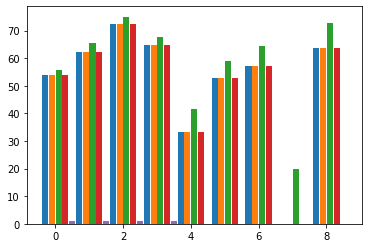

   burt_only  burt_LTSM128  burt_LTSM256  embd_LTSM256  training_sample
0         54            54            56            54             True
1         62            62            66            62             True
2         72            72            75            72             True
3         65            65            68            65             True
4         33            33            42            33            False
5         53            53            59            53            False
6         57            57            64            57            False
7          0             0            20             0            False
8         64            64            73            64            False


In [56]:
def plot_score():
    data = {}
    training_sample = []
    for i, name in enumerate(MODEL_NAMES):
        col_name = name + '_eval'
        arr = [statistics.mean(row) for row in df_models.groupby(['id'])[col_name].apply(list)]
        data[name] = arr

    for i in range(len(arr)):
        if i<len(X_train):
            training_sample.append(True)
        else:
            training_sample.append(False)
    data["training_sample"] = training_sample

    fig, ax = plt.subplots()
    bar_plot_utility(ax, data, total_width=.8, single_width=.9)
    plt.show()

    df_score = pd.DataFrame(data)
    pd.options.display.float_format = '{:,.0f}'.format
    print(df_score)
    return df_score

df_score = plot_score()

In [57]:
df_score

,burt_only,burt_LTSM128,burt_LTSM256,embd_LTSM256,training_sample
0,54,54,56,54,True
1,62,62,66,62,True
2,72,72,75,72,True
3,65,65,68,65,True
4,33,33,42,33,False
5,53,53,59,53,False
6,57,57,64,57,False
7,0,0,20,0,False
8,64,64,73,64,False


In [58]:
df_models

,id,true_category,burt_only_pred,burt_only_eval,burt_LTSM128_pred,burt_LTSM128_eval,burt_LTSM256_pred,burt_LTSM256_eval,embd_LTSM256_pred,embd_LTSM256_eval
0,11111,chief_complaint,examination,0,examination,0,examination,0,examination,0
1,11111,chief_complaint,examination,0,examination,0,examination,0,examination,0
2,11111,chief_complaint,examination,0,examination,0,examination,0,examination,0
3,11111,illness_hist,examination,0,examination,0,examination,0,examination,0
4,11111,chief_complaint,examination,0,examination,0,examination,0,examination,0
...,...,...,...,...,...,...,...,...,...,...
205,81118,examination,examination,100,examination,100,examination,100,examination,100
206,81118,examination,examination,100,examination,100,examination,100,examination,100
207,81118,examination,examination,100,examination,100,examination,100,examination,100
208,81118,diag_code,examination,0,examination,0,examination,0,examination,0
